In [8]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.stats import multivariate_normal
import pandas as pd
from scipy.spatial import ConvexHull
import scipy.stats as stats

plt.rcParams['font.sans-serif'] = "Arial"

# Figure 1 in the manuscript for the messy follow-the-leader-model

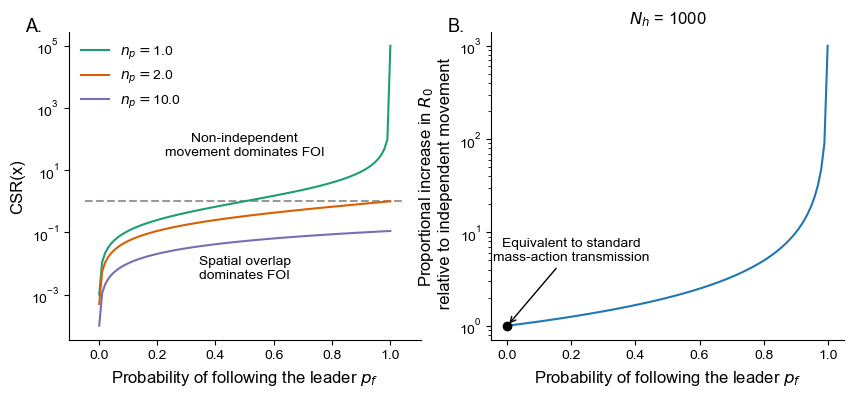

In [7]:
# Set-up figures
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.ravel()
colors = ['#1b9e77','#d95f02','#7570b3']

ax = axes[0]

pf_vals = np.linspace(0.001, 1, num=100) # Probability of following the leader
np_vals = [1.0, 2.0, 10.0] # Number of "areas of transmission" per patch
Nh = 100000 # Total number of patches on the landscape over which hosts move
rel_contrib = [] # Save results

# Use the analytical result in the main text to calculate CSR
for np_val in np_vals:
        rel_contrib.append((pf_vals*(Nh - 1)) / (Nh*(np_val - pf_vals) + pf_vals))

for i, rel in enumerate(rel_contrib):
    ax.semilogy(pf_vals, rel, label=r"$n_p = $" + "{0}".format(np_vals[i]), color=colors[i])
ax.legend(frameon=False)
ax.hlines(1, *ax.get_xlim(), color='black', linestyle='dashed', zorder=-1, alpha=0.4)
ax.set_ylabel(r"CSR(x)", size=12)
ax.set_xlabel("Probability of following the leader $p_f$", size=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0.5, 0.6, "Non-independent\nmovement dominates FOI", size=10, ha='center', transform=ax.transAxes)
ax.text(0.5, 0.2, "Spatial overlap\ndominates FOI", size=10, ha='center', transform=ax.transAxes)

# Plot of R0 values
ax = axes[1]

pf_vals = np.linspace(0, 1, num=100)
Nh_vals = [1000]

for i, Nh in enumerate(Nh_vals):
    R0 = 1 / (Nh*(1 - pf_vals) + pf_vals)
    R0_rel = R0 / R0[0]
    ax.semilogy(pf_vals, R0_rel)

ax.set_xlabel("Probability of following the leader $p_f$", size=12)
ax.set_ylabel("Proportional increase in $R_0$ \n relative to independent movement", size=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("$N_h$ = 1000")
ax.plot([0], [1], 'o', color='black')
ax.annotate("Equivalent to standard\nmass-action transmission", ha='center', xy=(0, 1), xytext=(0.2, 5), arrowprops=dict(arrowstyle="->"))

letters = ['A.', 'B.']
for i, ax in enumerate(axes):
    ax.text(-0.1, 1, letters[i], size=13, ha='center', transform=ax.transAxes)

plt.savefig("../results/follow_the_leader_results.pdf", bbox_inches="tight")

# Figure S1 in the Appendix: Calculate the OU-based correlation surface

## Simulate the OU process

In [12]:
# Attracting center
mu_center = np.array([0, 0, 0, 0])[:, np.newaxis]

# Drift back to the attracting center
drift = 0.05 # per hour
B = np.diag([drift, drift, drift, drift])

# Diffusion coefficients...m2 per hour, diffusion near the home range
D_diag = np.diag([150, 150, 150, 150])

rho = 0.9  # Social attraction
cormat = np.array([[1, 0, rho, 0],
                   [0, 1, 0, rho],
                   [rho, 0, 1, 0],
                   [0, rho, 0, 1]])

deltat = 1 / 6. # Time step is 10 minutes or 1 / 6 of an hour
D = D_diag @ cormat @ D_diag # Units of m2 per hour
Dm = D 

cov_mat = Dm - expm(-1*B*deltat) @ Dm @ expm(-1*B.T*deltat)

# Run the OU simulation
days = 365
steps = np.int64(days * 24 * (1 / deltat))
res = np.empty((4, steps + 1))

xinit = np.array([0, 0, 0, 0])[:, np.newaxis]
res[:, 0] = xinit.ravel()

for i in range(steps):
    
    xnow = res[:, i][:, np.newaxis]
    mu = mu_center + expm(-1*B*deltat)@(xnow - mu_center)
    res[:, i + 1] = np.random.multivariate_normal(mu.ravel(), cov_mat, size=1).ravel()

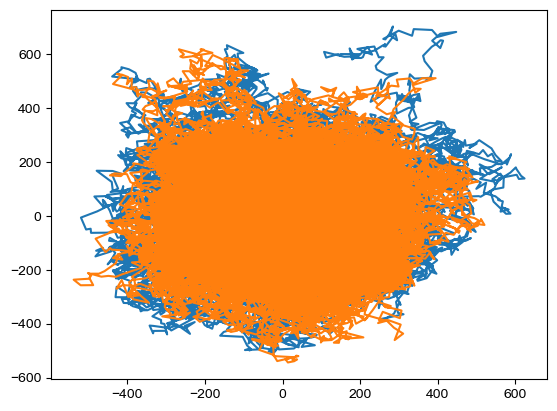

In [10]:
# Visulaize the OU movements
plt.plot(res[0, :], res[1, :], '-')
plt.plot(res[2, :], res[3, :], '-')

In [11]:
# Define the stationary distribution
mvn = multivariate_normal(mean=mu_center.ravel(), cov=Dm)

# Set landscape bounds
minx = -550
maxx = 550
miny = -550
maxy = 550

grid = 10 # Grid size in meters
xvals = np.arange(minx, maxx + grid, step=grid)
yvals = np.arange(minx, maxx + grid, step=grid)

X, Y = np.meshgrid(xvals, yvals)
xlong = X.ravel()
ylong = Y.ravel()

upper = np.vstack([xlong + grid*0.5, ylong + grid*0.5, xlong + grid*0.5, ylong + grid*0.5]).T
lower = np.vstack([xlong - grid*0.5, ylong - grid*0.5, xlong - grid*0.5, ylong - grid*0.5]).T
pbothinA = mvn.cdf(upper, lower_limit=lower).reshape(X.shape)

upper_other = np.vstack([xlong + grid*0.5, ylong + grid*0.5, np.repeat(np.inf, len(xlong)), np.repeat(np.inf, len(xlong))]).T
lower_other = np.vstack([xlong - grid*0.5, ylong - grid*0.5, np.repeat(-np.inf, len(xlong)), np.repeat(-np.inf, len(xlong))]).T

poneinA =  mvn.cdf(upper_other, lower_limit=lower_other).reshape(X.shape)

cov = pbothinA - poneinA*poneinA
sdinA = np.sqrt(poneinA*(1 - poneinA))

cor = cov / (sdinA*sdinA)

rel = cor*(sdinA**2) / poneinA**2
total_contrib = cor*(sdinA**2) + poneinA**2

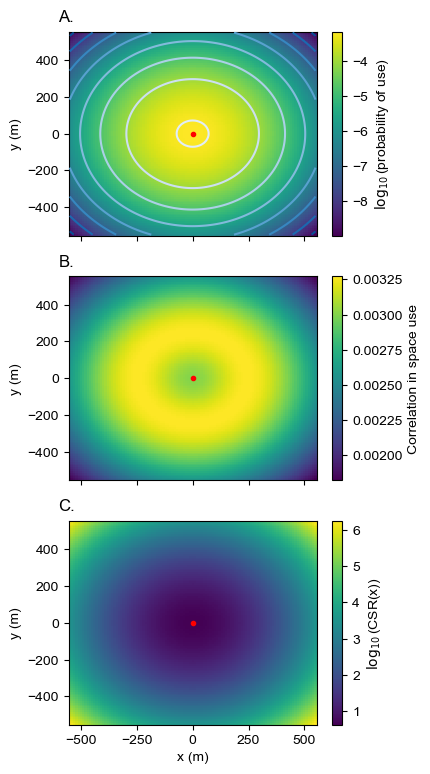

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(4, 9), sharex=True, sharey=True)
axes = axes.ravel()

cbar = axes[0].pcolormesh(X, Y, np.log10(poneinA), shading="auto", zorder=-1)
axes[0].contour(X, Y, np.log10(poneinA), zorder=10, cmap="Blues_r")
cb = fig.colorbar(cbar)
axes[0].set_ylabel("y (m)")
cb.set_label(r"$\log_{10}$(probability of use)")
#axes[0].set_title(r"Utilization distribution".format(rho))

cbar = axes[1].pcolormesh(X, Y, cor, shading="auto")
cb = fig.colorbar(cbar)
axes[1].set_ylabel("y (m)")
cb.set_label(r"Correlation in space use")
#axes[1].set_title(r"Pairwise correlation surface".format(rho))

cbar = axes[2].pcolormesh(X, Y, np.log10(rel), shading="auto")
cb = fig.colorbar(cbar)
axes[2].set_ylabel("y (m)")
axes[2].set_xlabel("x (m)")
cb.set_label(r"$\log_{10}$(CSR(x))")
#axes[2].set_title("Relative contribution of non-independent movement")
#plt.tight_layout()

letters = ['A.', 'B.', 'C.']
for i, ax in enumerate(axes):
    ax.text(-0.01, 1.05, letters[i], ha='center', size=12, transform=ax.transAxes) 
    ax.plot([0], [0], 'o', ms=3, color='red')

fig.savefig("../results/ou_surfaces.jpg", dpi=300, bbox_inches="tight")

# Figure 2 in the main text related to OU movements

0.1
0.2
0.3
0.5
0.7
0.9
0.95
0.99
0.999
0.9999
0.9999999
0.1
0.2
0.3
0.5
0.7
0.9
0.95
0.99
0.999
0.9999
0.9999999


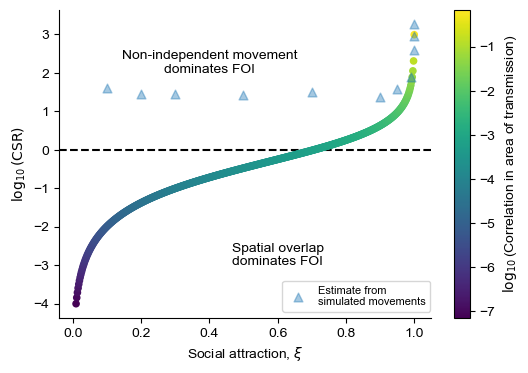

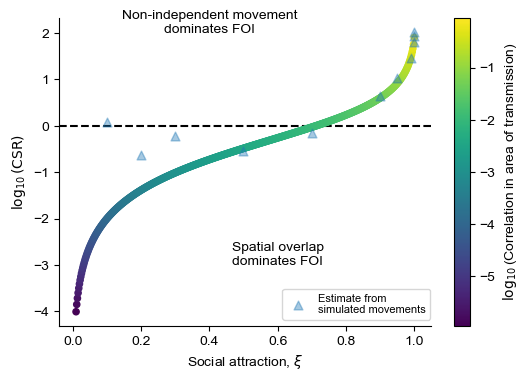

In [19]:
### Analytical analysis

upper_vals = [5, 20]
lower_vals = [-5, -20]

for u in range(len(upper_vals)):

    # Values for social attraction
    rho_values = np.linspace(0.01, 0.9999, num=500)
    
    cor_vals = np.empty(len(rho_values))
    rel_vals = np.empty(len(rho_values))
    
    # Calculate the joint probability of both individual being in the square bounded by upper and lower in x and y directions
    upper = upper_vals[u]
    lower = lower_vals[u]
    
    # Home range center is the sme for both individuals
    mu_center = np.array([0, 0, 0, 0])[:, np.newaxis]
    
    # Sigma, diffusion near the home range
    sigma = 150
    D_diag = np.diag([sigma, sigma, sigma, sigma])
        
    
    for i, rho in enumerate(rho_values):
    
        # Set up the social attraction matrix
        cormat = np.array([[1, 0, rho, 0],
                           [0, 1, 0, rho],
                           [rho, 0, 1, 0],
                           [0, rho, 0, 1]])
        
        deltat = 1 / 6. # Time step is 10 minutes or 1 / 6 of an hour
        D = D_diag @ cormat @ D_diag # Units of m2 per hour
        Dm = D 
        
        # Set up the multivaraite normal distribution describing space use
        mvn = multivariate_normal(mean=mu_center.ravel(), cov=Dm)
    
        # Probability both are in the area
        pbothinA = mvn.cdf([upper, upper, upper, upper], lower_limit=[lower, lower, lower, lower])
        
        # Probability that one is in the area, irrespective of the other
        poneinA =  mvn.cdf([upper, upper, np.inf, np.inf], lower_limit=[lower, lower, -np.inf, -np.inf])
        
        # Covariance in space use of A
        cov = pbothinA - poneinA*poneinA
        sdinA = np.sqrt(poneinA*(1 - poneinA))
        
        # Calculate the correlation
        cor = cov / (sdinA*sdinA)
        
        # Relative contribution
        rel_contribution = cor*(sdinA**2) / poneinA**2
    
        cor_vals[i] = cor
        rel_vals[i] = rel_contribution
        
    ### Simulate the OU process with drift and try to calculate correlation surface 
    
    rho_emp_vals = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 0.95, 1 - 1e-2, 1- 1e-3, 1- 1e-4, 1 - 1e-7]
    emp_rel_contrib = []
    emp_cor_vals = []
    
    # Diffusion coefficients...m2 per hour, diffusion near the home range
    drift = 0.05 # m per hour
    B = np.diag([drift, drift, drift, drift])
    
    sigma = 150
    D_diag = np.diag([sigma, sigma, sigma, sigma])
    
    days = 365 # One year of data
    steps = np.int64(days * 24 * (1 / deltat)) # 10 minute time steps in the units of hours
    
    for rho_emp in rho_emp_vals:
    
        print(rho_emp)
        mu_center = np.array([0, 0, 0, 0])[:, np.newaxis]
        
        cormat = np.array([[1, 0, rho_emp, 0],
                           [0, 1, 0, rho_emp],
                           [rho_emp, 0, 1, 0],
                           [0, rho_emp, 0, 1]])
        
        deltat = 1 / 6. # Time step is 10 minutes or 1 / 6 of an hour
        D = D_diag @ cormat @ D_diag # Units of m2 per hour
        Dm = D # Units of m2...it seems like we have to multiply by this factor to get the units right...I am probably doing something silly
    
        cov_mat = Dm - expm(-1*B*deltat) @ Dm @ expm(-1*B.T*deltat)
    
        res = np.empty((4, steps + 1))
        xinit = np.array([0, 0, 0, 0])[:, np.newaxis]
        res[:, 0] = xinit.ravel()
    
        for i in range(steps):
        
            xnow = res[:, i][:, np.newaxis]
            mu = mu_center + expm(-1*B*deltat)@(xnow - mu_center)
            res[:, i + 1] = np.random.multivariate_normal(mu.ravel(), cov_mat, size=1).ravel()
            
        # Calculate empirical contribution to FOI
        host1_inA = (pd.Series(res[0, :] < upper) & pd.Series(res[0, :] > lower) &
                     pd.Series(res[1, :] < upper) & pd.Series(res[1, :] > lower)).values.astype(np.int64)
        host2_inA = (pd.Series(res[2, :] < upper) & pd.Series(res[2, :] > lower) & 
                     pd.Series(res[3, :] < upper) & pd.Series(res[3, :] > lower)).values.astype(np.int64)
        
        emp_cor = np.corrcoef(host1_inA, host2_inA)[0, 1]
        prob1inA = np.mean(host1_inA)
        prob2inA = np.mean(host2_inA)
        cor_contrib = emp_cor*np.sqrt(prob1inA*(1 - prob1inA))*np.sqrt(prob2inA*(1 - prob2inA))
        overlap_contrib = prob1inA*prob2inA
        emp_contrib = np.abs(cor_contrib) / overlap_contrib
        emp_rel_contrib.append(emp_contrib)
        emp_cor_vals.append(emp_cor)

    # Make the figure

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    #ax.plot(rho_values, np.log(rel_vals), '-', lw=4)
    obj = ax.scatter(rho_values, np.log10(rel_vals), c=np.log10(cor_vals), s=20, zorder=10)
    cbar = fig.colorbar(obj)
    cbar.set_label(r"$\log_{10}$(Correlation in area of transmission)")
    xlim = ax.get_xlim()
    plt.hlines(0, *xlim, color="black", linestyle="dashed")
    ax.set_xlim(xlim)
    ax.set_xlabel(r"Social attraction, $\xi$")
    ax.set_ylabel(r"$\log_{10}(\text{CSR})$")
    ax.text(0.4, 2, "Non-independent movement\ndominates FOI", ha="center")
    ax.text(0.6, -3, "Spatial overlap\ndominates FOI", ha="center")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.scatter(rho_emp_vals, np.log10(emp_rel_contrib), marker='^', zorder=10, s=40, alpha=0.4, label="Estimate from\nsimulated movements")
    ax.legend(loc=(0.6, 0.02), prop={'size': 8}, frameon=True)
    width = upper - lower
    fig.savefig("../results/relative_contrib_at_grid_cell_{0}.pdf".format(width), bbox_inches="tight")

# Figure 3: The effect of non-independent movement on FOI given indirect transmission

In [20]:
# Set-up the OU process
rho_vals = [1 - 1e-4, 0.9, 0.5]
drift_vals = [1, 0.005]
all_cor_fxns = [] # Save the correlation functions
all_poneinA = [] # Save the probability of being in A
time_step = (1 / 6.) # 10 minutes with hour units

for drift in drift_vals:
    for rho in rho_vals:

        print((rho, drift))
        B = np.diag([drift, drift, drift, drift])
        
        sigma = 150
        D_diag = np.diag([sigma, sigma, sigma, sigma])
        mu_center = np.array([0, 0, 0, 0])[:, np.newaxis]
        
        #rho = [0.5, 0.9, 1 - 1e-4]
        cormat = np.array([[1, 0, rho, 0],
                           [0, 1, 0, rho],
                           [rho, 0, 1, 0],
                           [0, rho, 0, 1]])
        
        lags = np.arange(0, 5000) # 5000 lags of 10 minutes is ~ 34 days
        cor_function = np.empty(len(lags))
        
        for i, lag in enumerate(lags):
        
            deltat = lag*time_step # per hour
            D = D_diag @ cormat @ D_diag
            Dm = D 
            
            eB = expm(-B*deltat) @ Dm
            
            # Set-up the full multivariate normal
            Sigma = np.block([[Dm, eB], 
                              [eB, Dm]])
            mu_full = np.block([[mu_center], [mu_center]])
            mvn = multivariate_normal(mean=mu_full.ravel(), cov=Sigma, allow_singular=True)
            
            # To calculate [2 in x at t + dt and 1 in x at t]
            upper = 5
            lower = -5
            
            # Probability both are in the area
            pbothinA = mvn.cdf([upper, upper, np.inf, np.inf, np.inf, np.inf, upper, upper], 
                               lower_limit=[[lower, lower, -np.inf, -np.inf, -np.inf, -np.inf, lower, lower]])
            
            # Probability one in area
            poneinA = mvn.cdf([upper, upper, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf], 
                               lower_limit=[[lower, lower, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]])
            
            # Calculate correlation
            cov = pbothinA - poneinA*poneinA
            sdinA = np.sqrt(poneinA*(1 - poneinA))
            cor = cov / (sdinA*sdinA)
            
            cor_function[i] = cor

        # Save the correlation function
        all_cor_fxns.append(cor_function)
        all_poneinA.append(poneinA)

(0.9999, 1)
(0.9, 1)
(0.5, 1)
(0.9999, 0.005)
(0.9, 0.005)
(0.5, 0.005)


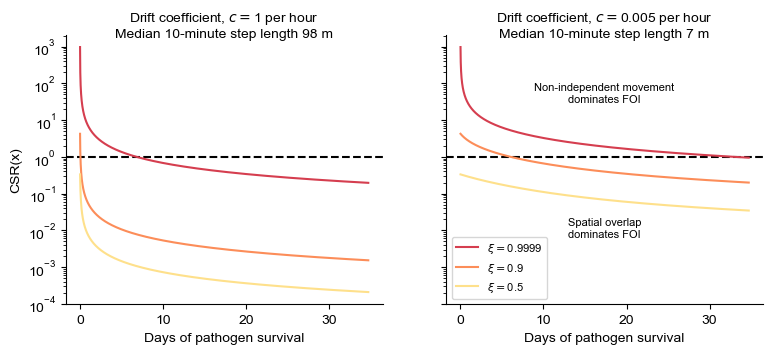

In [22]:
lags = np.arange(1, 5000)
n = len(all_cor_fxns)
step_lengths = [98, 7]# Computed speicifically for c = [0.005, 10]
colors = ['#d53e4f','#fc8d59','#fee08b']

fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), sharex=True, sharey=True)

countr = 0
for i in range(len(all_cor_fxns)):
    
    rel_contrib_exact = []
    cor_function = all_cor_fxns[i]
    poneinA = all_poneinA[i]
    sdinA = np.sqrt(poneinA*(1 - poneinA))

    # Compute the FOI for different lags
    for lag in lags:
    
        total_time = time_step*lag
        spatial_contrib = poneinA*poneinA*total_time
        cor_contrib = sdinA*sdinA*np.sum(cor_function[:lag]*time_step)
        rel_contrib_exact.append(cor_contrib / spatial_contrib)

    if i <= 2:
        k = 0
    else:
        k = 1

    if k == 0:
        axes[k].semilogy((lags * 10) / (60*24), rel_contrib_exact, color=colors[i])
        axes[k].set_xlabel("Days of pathogen survival", size=10)
    else:
        axes[k].semilogy((lags * 10) / (60*24), rel_contrib_exact, color=colors[i % 3], label=r"$\xi = $" + "{0}".format(rho_vals[countr]))
        axes[k].set_xlabel("Days of pathogen survival", size=10)
        countr += 1
        

xlim = axes[0].get_xlim()
letters = ["A.", "B."]

for j in range(len(axes)):
    axes[j].hlines(1, *xlim, color='black', linestyle="dashed", zorder=-1)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].text(0.5, 0.99, "Drift coefficient, $c = $" + "{0} per hour\nMedian 10-minute step length {1} m".format(drift_vals[j], step_lengths[j]), ha='center', transform=axes[j].transAxes) 
    #axes[j].text(-0.05, 1, letters[j], size=14, ha='center', transform=axes[j].transAxes)

    
    if j == 0:
        axes[j].set_ylabel("CSR(x)")

    if j == 1:
        axes[j].text(0.5, 0.75, "Non-independent movement\ndominates FOI", size=8, ha='center', transform=axes[j].transAxes)
        axes[j].text(0.5, 0.25, "Spatial overlap\ndominates FOI", size=8, ha='center', transform=axes[j].transAxes)
        axes[j].legend(loc="lower left", prop={'size': 8})

    
axes[0].set_xlim(*xlim)
fig.savefig("../results/indirect_contribution.pdf", bbox_inches="tight")

# Make OU simulations for visualization purposes

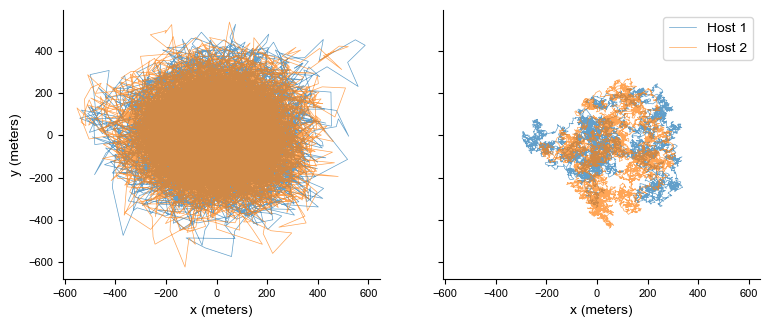

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), sharex=True, sharey=True)
axes = axes.ravel()

drift_vals = [1, 0.005]
rho_emp = 0.9 # 1 - 1e-2,  1 - 1e-3, 1 - 1e-4, 1 - 1e-5, 1 - 1e-6, 1 - 1e-7]
emp_rel_contrib = []
emp_cor_vals = []

sigma = 150
D_diag = np.diag([sigma, sigma, sigma, sigma])

deltat = 1 / 6. # Time step is 10 minutes or 1 / 6 of an hour
days = 60 # Long simulation to help with the calculation
steps = np.int64(days * 24 * (1 / deltat))

for d, drift in enumerate(drift_vals):

    B = np.diag([drift, drift, drift, drift])
    mu_center = np.array([0, 0, 0, 0])[:, np.newaxis]
    
    cormat = np.array([[1, 0, rho_emp, 0],
                       [0, 1, 0, rho_emp],
                       [rho_emp, 0, 1, 0],
                       [0, rho_emp, 0, 1]])
    
    deltat = 1 / 6. # Time step is 10 minutes or 1 / 6 of an hour
    D = D_diag @ cormat @ D_diag # Units of m2 per hour
    Dm = D # Units of m2...it seems like we have to multiply by this factor to get the units right...I am probably doing something silly

    cov_mat = Dm - expm(-1*B*deltat) @ Dm @ expm(-1*B.T*deltat)

    res = np.empty((4, steps + 1))
    xinit = np.array([0, 0, 0, 0])[:, np.newaxis]
    res[:, 0] = xinit.ravel()

    for i in range(steps):
    
        xnow = res[:, i][:, np.newaxis]
        mu = mu_center + expm(-1*B*deltat)@(xnow - mu_center)
        res[:, i + 1] = np.random.multivariate_normal(mu.ravel(), cov_mat, size=1).ravel()

    axes[d].plot(res[0, :], res[1, :], '-', lw=0.5, alpha=0.7, label="Host 1")
    axes[d].plot(res[2, :], res[3, :], '-', lw=0.5, alpha=0.7, label="Host 2")

    axes[d].spines['right'].set_visible(False)
    axes[d].spines['top'].set_visible(False)
    axes[d].tick_params(labelsize=8)

    axes[d].set_xlabel("x (meters)")

    if d == 0:
        axes[d].set_ylabel("y (meters)")


# letters = ["C.", "D."]
# for i, ax in enumerate(axes):
#     ax.text(-0.05, 1, letters[i], size=14, ha='center', transform=ax.transAxes)

axes[1].legend()
fig.savefig("../results/host_trajectory.pdf", bbox_inches="tight")
